In [1]:
import pandas as pd
import numpy as np
from scipy.stats import ecdf, ks_2samp, wasserstein_distance  # Kolmogorov-Smirnov test

import matplotlib.pyplot as plt
import seaborn as sns

df_all_ex1 = pd.read_feather('df_complete_ex1.feather')
df_all_ex3 = pd.read_feather('df_complete_ex3.feather')


# Cell population - AUC

The area under the curve (AUC) of cell population over time provides insights into the dynamics of different cell types in the simulation. The AUC is calculated for each cell type (live and dead) to quantify their population changes throughout the experiment.

- **Tumor Live Cells**: The AUC for tumor live cells represents the total number of live tumor cells over time. This metric helps in understanding the growth and survival rate of tumor cells.
- **Motile Live Cells**: The AUC for motile live cells indicates the population dynamics of motile tumor cells, which are typically more invasive and can migrate.
- **Tumor Dead Cells**: The AUC for tumor dead cells shows the cumulative number of dead tumor cells, providing insights into the cell death rate.
- **Motile Dead Cells**: The AUC for motile dead cells reflects the death rate of motile tumor cells.

These AUC values are visualized using a stacked area plot, where each cell type's population is plotted over time, allowing for a clear comparison of their dynamics.

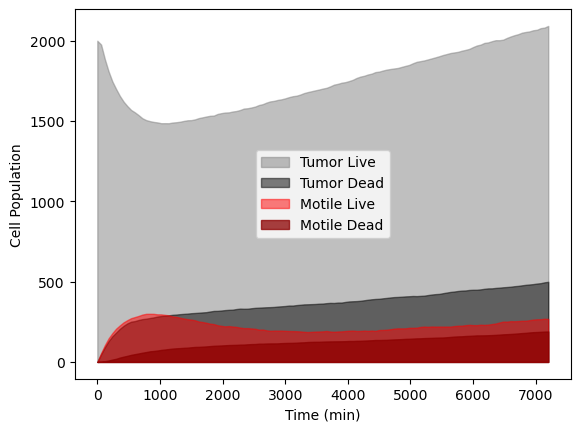

In [30]:

# Reference sample, mean across all replicates
df_ref1 = df_all_ex1[df_all_ex1['sample'] == 0][['time', 'replicate', 'tumor_live', 'motile_live', 'tumor_dead', 'motile_dead']]
df_ref1_mean = df_ref1.groupby(['time'], as_index=False).mean()

# Plotting AUC
fig, ax = plt.subplots()
ax.fill_between(df_ref1_mean['time'], df_ref1_mean['tumor_live'], 0, alpha=0.5, label='Tumor Live', color='gray')
ax.fill_between(df_ref1_mean['time'], df_ref1_mean['tumor_dead'], 0, alpha=0.5, label='Tumor Dead', color='black')
ax.fill_between(df_ref1_mean['time'], df_ref1_mean['motile_live'], 0, alpha=0.5, label='Motile Live', color='red')
ax.fill_between(df_ref1_mean['time'], df_ref1_mean['motile_dead'], 0, alpha=0.75, label='Motile Dead', color='darkred')
ax.set(xlabel='Time (min)', ylabel='Cell Population')
ax.legend()

# Cell Invasion - distance from the center (last snapshot)

## Distance from the Computational Center and Invasion Analysis

The distance from the computational center (0,0,0) for each cell type provides insights into the spatial distribution and invasion characteristics of the cells. This analysis helps in understanding the extent of cell migration and invasion in the simulated environment.

### Cell Types and Distances
- **Tumor Live Cells**: The distances of live tumor cells from the center indicate their spread and potential invasion into surrounding tissues.
- **Tumor Dead Cells**: The distances of dead tumor cells help in understanding the regions where cell death is more prevalent.
- **Motile Live Cells**: The distances of live motile tumor cells are crucial as these cells are typically more invasive and capable of migrating further from the center.
- **Motile Dead Cells**: The distances of dead motile tumor cells provide insights into the regions where these invasive cells are more likely to die.

### Invasion Analysis
To investigate the invasion characteristics, we use two statistical tests:
- **Kolmogorov-Smirnov Test**: This test compares the empirical cumulative distribution functions (CDFs) of two samples to determine if they are from the same distribution. The maximum distance between the two CDFs indicates the extent of difference between the distributions.
- **Wasserstein Distance**: This metric measures the distance between two probability distributions. It provides a quantitative measure of the difference in spatial distribution between two cell types.


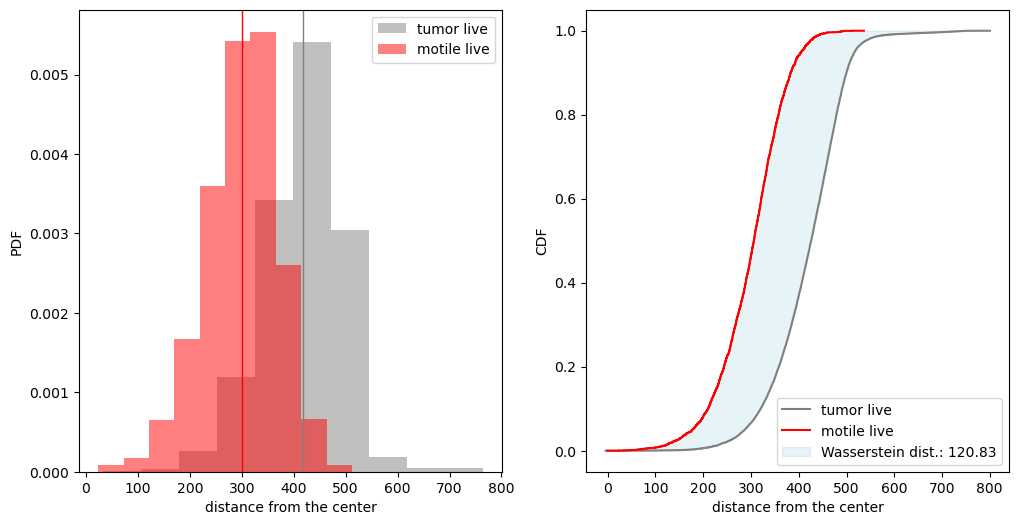

In [16]:
# Reference sample, mean across all replicates in the last point
df_ref1_dist = df_all_ex1[ (df_all_ex1['sample'] == 0) & (df_all_ex1['time'] == 7200)][['time', 'replicate', 'dist_tumor_live', 'dist_motile_live']]
# concatenate the samples
dist_dics = {}
concatenate_cols = ['dist_tumor_live', 'dist_motile_live']
for col in concatenate_cols:
    dist_dics[col] = np.concatenate(df_ref1_dist[col].to_numpy())

# Store the concatenated columns
dist_tumor_live = pd.Series(dist_dics['dist_tumor_live'])
dist_motile_live = pd.Series(dist_dics['dist_motile_live'])

# Define empirical distributions of live cells
emp_liveTumor_cdf = ecdf(dist_tumor_live)
emp_liveMotile_cdf = ecdf(dist_motile_live)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# plot pdf approximations and means
dist_tumor_live.plot(kind='hist', bins=10, density=True, alpha=0.5, ax=ax1, legend=True, label='tumor live', color='gray')
dist_motile_live.plot(kind='hist', bins=10, density=True, alpha=0.5, ax=ax1, legend=True, label='motile live', color='red')
ax1.axvline(dist_tumor_live.mean(), color='gray', linestyle='solid', linewidth=1)
# ax1.axvline(dist_tumor_live.mean()+dist_tumor_live.std(), color='blue', linestyle='dashed', linewidth=1, label='tumor live std')
# ax1.axvline(dist_tumor_live.mean()-dist_tumor_live.std(), color='blue', linestyle='dashed', linewidth=1)
ax1.axvline(dist_motile_live.mean(), color='red', linestyle='solid', linewidth=1)
# ax1.axvline(dist_motile_live.mean()+dist_motile_live.std(), color='orange', linestyle='dashed', linewidth=1, label='motile live std')
# ax1.axvline(dist_motile_live.mean()-dist_motile_live.std(), color='orange', linestyle='dashed', linewidth=1)
ax1_set = ax1.set(xlabel='distance from the center', ylabel='PDF')
ax1.legend()

# plot empirical cdf 
emp_liveTumor_cdf.cdf.plot(ax=ax2, label='tumor live', color='gray')
emp_liveMotile_cdf.cdf.plot(ax=ax2, label='motile live', color='red')
# plot the area between CDFs - Wasserstein distance
# interpolate emp_liveMotile_cdf to match the length of emp_liveTumor_cdf
interp_probabilities = np.interp(emp_liveTumor_cdf.cdf.quantiles, emp_liveMotile_cdf.cdf.quantiles, emp_liveMotile_cdf.cdf.probabilities)
wassersteinDistance = wasserstein_distance(emp_liveTumor_cdf.cdf.quantiles, emp_liveMotile_cdf.cdf.quantiles, emp_liveTumor_cdf.cdf.probabilities, emp_liveMotile_cdf.cdf.probabilities)
ax2.fill_between(emp_liveTumor_cdf.cdf.quantiles, emp_liveTumor_cdf.cdf.probabilities, interp_probabilities, alpha=0.3, interpolate=True,color='lightblue', label=f'Wasserstein dist.: {wassersteinDistance:.2f}')
# plot the maximum distance between the two CDFs - Kolmogorov-sminorf test
# max_distance = np.max(np.abs(emp_liveTumor_cdf.cdf.probabilities - interp_probabilities))
# max_distance_index = np.argmax(np.abs(emp_liveTumor_cdf.cdf.probabilities - interp_probabilities))
# ax2.plot([emp_liveTumor_cdf.cdf.quantiles[max_distance_index]]*2, 
#          [emp_liveTumor_cdf.cdf.probabilities[max_distance_index], interp_probabilities[max_distance_index]], 
#          color='black', linestyle='-', linewidth=1,marker='o', label=f'KS test: {max_distance:.2f}')

ax2_set = ax2.set(xlabel='distance from the center', ylabel='CDF')
ax2.legend()

plt.show()

# Example 3: Simple tumor-immune model

<Axes: xlabel='x', ylabel='y'>

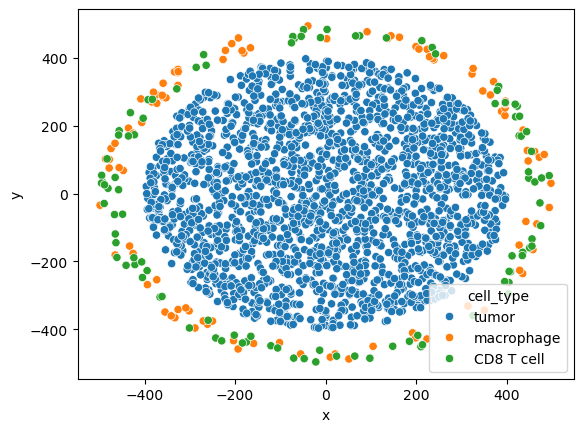

In [4]:
import numpy as np
import matplotlib.pyplot as plt

def initial_condition_random_annulus(fraction=1.0, fileName=None):
    # Set a new random seed each time to ensure different random numbers are generated
    np.random.seed()
    zval = 0;
    csv_array = np.empty((0, 4), dtype=[('x', 'float64'), ('y', 'float64'), ('z', 'float64'), ('cell_type', 'U20')])
    cell_types = {'tumor': 2000, 'macrophage': 100*fraction, 'CD8 T cell': 100*fraction}
    for cell_type in cell_types.keys():
        num_cells = cell_types[cell_type]
        count_cell = 0
        if cell_type == 'tumor':
            Radius_inner = 0
            Radius_external = 400
        else:
            Radius_inner = 450
            Radius_external = 500
        while count_cell < num_cells:
            t = 2.0 * np.pi * np.random.uniform() # theta ~ U(0,2pi)
            r = np.sqrt(np.random.uniform(Radius_inner**2, Radius_external**2))  # radius ~ sqrt(U(Radius_inner^2, Radius_external^2))
            xval = r * np.cos(t)
            yval = r * np.sin(t)
            # print(xval, yval, zval, cell_type)
            csv_array = np.append(csv_array, np.array([(xval, yval, zval, cell_type)], dtype=csv_array.dtype))
            count_cell += 1
    if fileName:
        header="x,y,z,type,volume,cycle entry,custom:GFP,custom:sample"
        np.savetxt(fileName, csv_array, header=header, delimiter=',', fmt='%.14f,%.14f,%f,%s', comments='')
    else:
        return csv_array
        
df_IC = pd.DataFrame(initial_condition_random_annulus(), columns=['x', 'y', 'z', 'cell_type'])
sns.scatterplot(x='x', y='y', hue='cell_type', data=df_IC)

# AUC from reference parameter set

/var/folders/z0/qjtn97gj62z2_f7wmwlwkvmc0000gn/T/ipykernel_95602/3068196046.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax2.legend(loc='upper right')


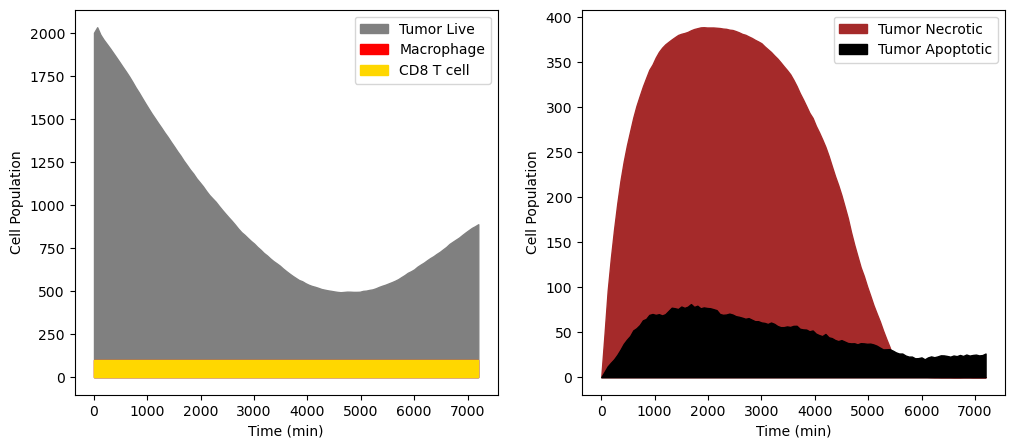

In [9]:

# Reference sample, mean across all replicates
df_ref3 = df_all_ex3[df_all_ex3['sample'] == 0][['time', 'replicate', 'tumor_live', 'tumor_apop', 'tumor_nec', 'macrophage', 'CD8 T cell']]
df_ref3_mean = df_ref3.groupby(['time'], as_index=False).mean()

# Plotting AUC
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.fill_between(df_ref3_mean['time'], df_ref3_mean['tumor_live'], 0, alpha=1, label='Tumor Live', color='gray')
ax1.fill_between(df_ref3_mean['time'], df_ref3_mean['macrophage'], 0.75, alpha=1, label='Macrophage', color='red')
ax1.fill_between(df_ref3_mean['time'], df_ref3_mean['CD8 T cell'], 0.75, alpha=1, label='CD8 T cell', color='gold')
ax1.set(xlabel='Time (min)', ylabel='Cell Population')
ax1.legend()

ax2.legend(loc='upper right')
ax2.fill_between(df_ref3_mean['time'], df_ref3_mean['tumor_nec'], 0, alpha=1, label='Tumor Necrotic', color='brown')
ax2.fill_between(df_ref3_mean['time'], df_ref3_mean['tumor_apop'], 0, alpha=1, label='Tumor Apoptotic', color='black')
ax2.set(xlabel='Time (min)', ylabel='Cell Population')
ax2.legend()

<Axes: xlabel='time', ylabel='tumor_live'>

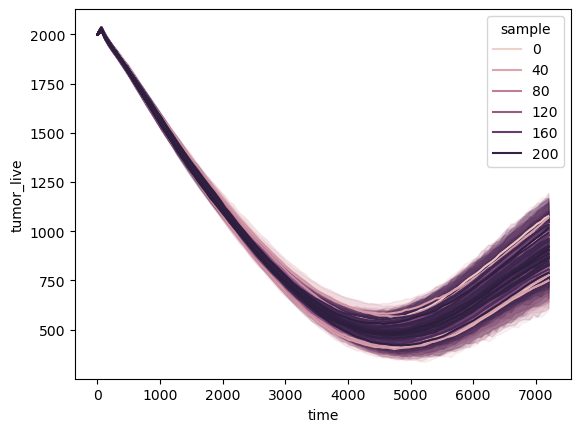

In [35]:
sns.lineplot(data=df_all_ex3, x ='time', y='tumor_live', hue='sample')

# Wassertein distances

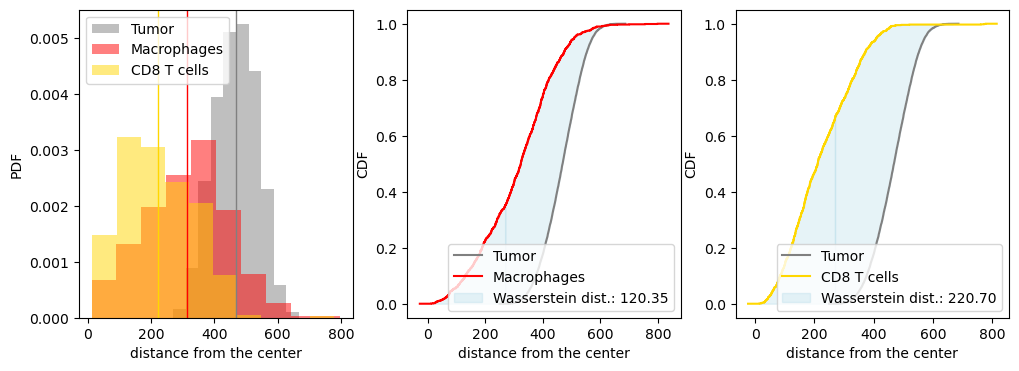

In [15]:
# Reference sample, mean across all replicates in the last point
df_ref3_dist = df_all_ex3[ (df_all_ex3['sample'] == 0) & (df_all_ex3['time'] == 7200)][['time', 'replicate', 'dist_tumor_live', 'dist_tumor_apop', 'dist_tumor_nec', 'dist_mac', 'dist_cd8']]
df_ref3_dist['dist_tumor'] = df_ref3_dist.apply( lambda row: np.concatenate((row['dist_tumor_live'], row['dist_tumor_apop'], row['dist_tumor_nec'])), axis=1 )
df_ref3_dist = df_ref3_dist.drop(columns=['dist_tumor_live', 'dist_tumor_apop', 'dist_tumor_nec'])

# concatenate the samples
dist_dics3 = {}
concatenate_cols = ['dist_tumor', 'dist_mac', 'dist_cd8']
for col in concatenate_cols:
    dist_dics3[col] = np.concatenate(df_ref3_dist[col].to_numpy())

# Store the concatenated columns
dist_tumor = pd.Series(dist_dics3['dist_tumor'])
dist_mac = pd.Series(dist_dics3['dist_mac'])
dist_cd8 = pd.Series(dist_dics3['dist_cd8'])

# Define empirical distributions of live cells
emp_Tumor_cdf = ecdf(dist_tumor)
emp_Mac_cdf = ecdf(dist_mac)
emp_CD8_cdf = ecdf(dist_cd8)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))

# plot pdf approximations and means
dist_tumor.plot(kind='hist', bins=10, density=True, alpha=0.5, ax=ax1, legend=True, label='Tumor', color='gray')
dist_mac.plot(kind='hist', bins=10, density=True, alpha=0.5, ax=ax1, legend=True, label='Macrophages', color='red')
dist_cd8.plot(kind='hist', bins=10, density=True, alpha=0.5, ax=ax1, legend=True, label='CD8 T cells', color='gold')
ax1.axvline(dist_tumor.mean(), color='gray', linestyle='solid', linewidth=1)
ax1.axvline(dist_mac.mean(), color='red', linestyle='solid', linewidth=1)
ax1.axvline(dist_cd8.mean(), color='gold', linestyle='solid', linewidth=1)
ax1_set = ax1.set(xlabel='distance from the center', ylabel='PDF')
ax1.legend()

# plot empirical cdf - tumor - macrophages
emp_Tumor_cdf.cdf.plot(ax=ax2, label='Tumor', color='gray')
emp_Mac_cdf.cdf.plot(ax=ax2, label='Macrophages', color='red')
# plot the area between CDFs - Wasserstein distance
wassersteinDistance = wasserstein_distance(emp_Tumor_cdf.cdf.quantiles, emp_Mac_cdf.cdf.quantiles, emp_Tumor_cdf.cdf.probabilities, emp_Mac_cdf.cdf.probabilities)
# interpolate emp_liveMotile_cdf to match the length of emp_liveTumor_cdf
interp_probabilities_mac = np.interp(emp_Tumor_cdf.cdf.quantiles, emp_Mac_cdf.cdf.quantiles, emp_Mac_cdf.cdf.probabilities)
# interpolate emp_Tumor_cdf to match the length of emp_CD8_cdf
interp_probabilities_tumor = np.interp(emp_Mac_cdf.cdf.quantiles, emp_Tumor_cdf.cdf.quantiles, emp_Tumor_cdf.cdf.probabilities)
# interp_probabilities_tumor = np.interp(emp_CD8_cdf.cdf.quantiles, emp_Tumor_cdf.cdf.quantiles, emp_Tumor_cdf.cdf.probabilities)
ax2.fill_between(emp_Tumor_cdf.cdf.quantiles, emp_Tumor_cdf.cdf.probabilities, interp_probabilities_mac, alpha=0.3,
                 where=(emp_Tumor_cdf.cdf.quantiles > emp_Mac_cdf.cdf.quantiles[0]), interpolate=True, color='lightblue', label=f'Wasserstein dist.: {wassersteinDistance:.2f}')
ax2.fill_between(emp_Mac_cdf.cdf.quantiles, emp_Mac_cdf.cdf.probabilities, interp_probabilities_tumor, alpha=0.3,
                 where=(emp_Mac_cdf.cdf.quantiles < emp_Tumor_cdf.cdf.quantiles[0]), interpolate=True, color='lightblue')
# plot the maximum distance between the two CDFs - Kolmogorov-sminorf test
# max_distance = np.max(np.abs(emp_Tumor_cdf.cdf.probabilities - interp_probabilities))
# max_distance_index = np.argmax(np.abs(emp_Tumor_cdf.cdf.probabilities - interp_probabilities))
# ax2.plot([emp_Tumor_cdf.cdf.quantiles[max_distance_index]]*2, 
#          [emp_Tumor_cdf.cdf.probabilities[max_distance_index], interp_probabilities[max_distance_index]], 
#          color='black', linestyle='-', linewidth=1,marker='o', label=f'KS test: {max_distance:.2f}')

ax2_set = ax2.set(xlabel='distance from the center', ylabel='CDF')
ax2.legend()

# plot empirical cdf - tumor - CD8 T cells
emp_Tumor_cdf.cdf.plot(ax=ax3, label='Tumor', color='gray')
emp_CD8_cdf.cdf.plot(ax=ax3, label='CD8 T cells', color='gold')
# plot the area between CDFs - Wasserstein distance
wassersteinDistance = wasserstein_distance(emp_Tumor_cdf.cdf.quantiles, emp_CD8_cdf.cdf.quantiles, emp_Tumor_cdf.cdf.probabilities, emp_CD8_cdf.cdf.probabilities)
# interpolate emp_CD8_cdf to match the length of emp_Tumor_cdf
interp_probabilities_cd8 = np.interp(emp_Tumor_cdf.cdf.quantiles, emp_CD8_cdf.cdf.quantiles, emp_CD8_cdf.cdf.probabilities)
# interpolate emp_Tumor_cdf to match the length of emp_CD8_cdf
interp_probabilities_tumor = np.interp(emp_CD8_cdf.cdf.quantiles, emp_Tumor_cdf.cdf.quantiles, emp_Tumor_cdf.cdf.probabilities)
ax3.fill_between(emp_Tumor_cdf.cdf.quantiles, emp_Tumor_cdf.cdf.probabilities, interp_probabilities_cd8, alpha=0.3,
                 where=(emp_Tumor_cdf.cdf.quantiles > emp_CD8_cdf.cdf.quantiles[0]), interpolate=True, color='lightblue', label=f'Wasserstein dist.: {wassersteinDistance:.2f}')
ax3.fill_between(emp_CD8_cdf.cdf.quantiles, emp_CD8_cdf.cdf.probabilities, interp_probabilities_tumor, alpha=0.3,
                 where=(emp_CD8_cdf.cdf.quantiles < emp_Tumor_cdf.cdf.quantiles[0]), interpolate=True, color='lightblue')
# plot the maximum distance between the two CDFs - Kolmogorov-sminorf test
# max_distance = np.max(np.abs(emp_Tumor_cdf.cdf.probabilities - interp_probabilities))
# max_distance_index = np.argmax(np.abs(emp_Tumor_cdf.cdf.probabilities - interp_probabilities))
# ax3.plot([emp_Tumor_cdf.cdf.quantiles[max_distance_index]]*2, 
#          [emp_Tumor_cdf.cdf.probabilities[max_distance_index], interp_probabilities[max_distance_index]], 
#          color='black', linestyle='-', linewidth=1,marker='o', label=f'KS test: {max_distance:.2f}')

ax3_set = ax3.set(xlabel='distance from the center', ylabel='CDF')
ax3.legend()

plt.show()